In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler,LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, f1_score
from xgboost import XGBClassifier, plot_importance
from xgboost import callback
import joblib
import shap
%matplotlib inline

In [4]:
# Load the dataset
file_path = "./UAVNet-Defense Comprehensive UAV Network Traffic Dataset.csv"
df = pd.read_csv(file_path)

In [5]:
# Encode 'Protocol' and 'label'
protocol_encoder = LabelEncoder()
df["Protocol"] = protocol_encoder.fit_transform(df["Protocol"])

In [6]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
print("\nLabel Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Label Mapping: {'AODV Attack': 0, 'Flooding Attack': 1, 'Legitimate AODV Traffic': 2, 'Normal Traffic': 3, 'Sybil Attack': 4}


In [7]:
# Define feature columns and label column
feature_columns = [
    "FlowDuration/s", "SrcPort", "DstPort", "Protocol",
    "TxPackets", "RxPackets", "LostPackets", "TxBytes", "RxBytes",
    "TxPacketRate/s", "RxPacketRate/s", "TxByteRate/s", "RxByteRate/s",
    "MeanDelay/s", "MeanJitter/s", "Throughput/Kbps",
    "MeanPacketSize", "PacketDropRate", "AverageHopCount"
]
label_column = "label"

In [8]:
# Apply RobustScaler
scaler = RobustScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Prepare the data
X = df[feature_columns]
y = df[label_column]

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 34236, Testing samples: 8559


In [10]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}


In [11]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_), random_state=42)

In [12]:
# Initialize RandomizedSearchCV
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

# Fit the model without early stopping
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                           n_estimators=None, n_jobs=None,
                                           num_class=5, num_parallel_tree=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [13]:
# Get the best hyperparameters
best_params = random_search.best_params_
print("\nBest Hyperparameters:", best_params)


Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [14]:
# Initialize the XGBoost model with the best parameters
best_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    random_state=42,
    **best_params
)

In [15]:
# Define early stopping callback
early_stopping = callback.EarlyStopping(rounds=10, save_best=True)

In [16]:
# Fit the model with early stopping and eval_metric
best_xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)]
)

[0]	validation_0-mlogloss:1.39336
[1]	validation_0-mlogloss:1.22444
[2]	validation_0-mlogloss:1.08696
[3]	validation_0-mlogloss:0.97285
[4]	validation_0-mlogloss:0.87586
[5]	validation_0-mlogloss:0.79212
[6]	validation_0-mlogloss:0.71928
[7]	validation_0-mlogloss:0.65505
[8]	validation_0-mlogloss:0.59876
[9]	validation_0-mlogloss:0.54870
[10]	validation_0-mlogloss:0.50453
[11]	validation_0-mlogloss:0.46500
[12]	validation_0-mlogloss:0.42933
[13]	validation_0-mlogloss:0.39737
[14]	validation_0-mlogloss:0.36870
[15]	validation_0-mlogloss:0.34312
[16]	validation_0-mlogloss:0.31995
[17]	validation_0-mlogloss:0.29915
[18]	validation_0-mlogloss:0.28040
[19]	validation_0-mlogloss:0.26327
[20]	validation_0-mlogloss:0.24775
[21]	validation_0-mlogloss:0.23355
[22]	validation_0-mlogloss:0.22099
[23]	validation_0-mlogloss:0.20931
[24]	validation_0-mlogloss:0.19873
[25]	validation_0-mlogloss:0.18914
[26]	validation_0-mlogloss:0.18031
[27]	validation_0-mlogloss:0.17241
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [26]:
# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                         precision    recall  f1-score   support

            AODV Attack       0.95      0.93      0.94      1813
        Flooding Attack       0.99      0.97      0.98       194
Legitimate AODV Traffic       0.98      0.98      0.98      5155
         Normal Traffic       1.00      1.00      1.00      1150
           Sybil Attack       0.98      1.00      0.99       247

               accuracy                           0.97      8559
              macro avg       0.98      0.97      0.98      8559
           weighted avg       0.97      0.97      0.97      8559



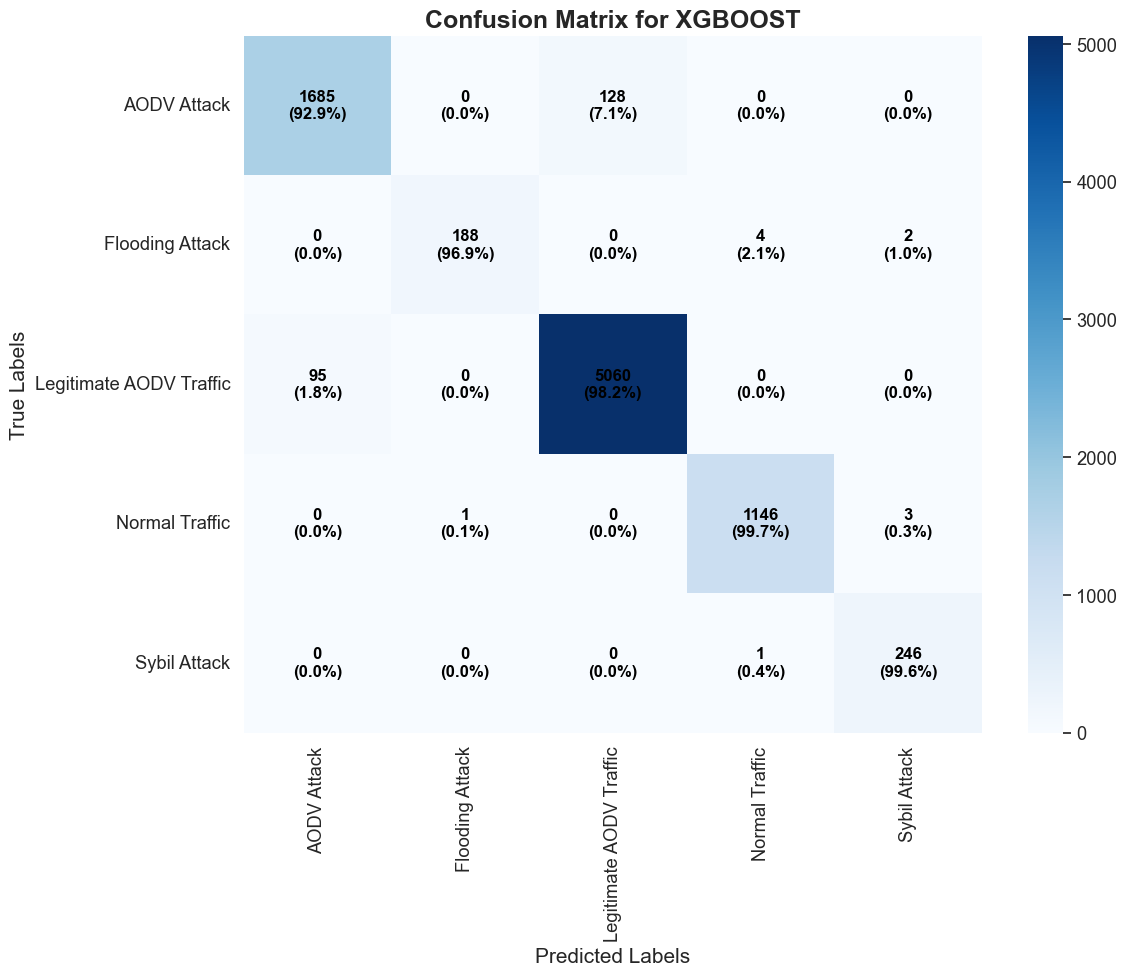

In [45]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

heatmap = sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for XGBOOST", fontsize=18, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=15)
plt.ylabel("True Labels", fontsize=15)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percentage = conf_matrix_normalized[i, j] * 100
        heatmap.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1f}%)", ha='center', va='center', color="black", fontsize=12, fontweight='bold')

plt.grid(False)
plt.tight_layout()
plt.savefig("normalized_confusion_matrix_xgboost_model.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

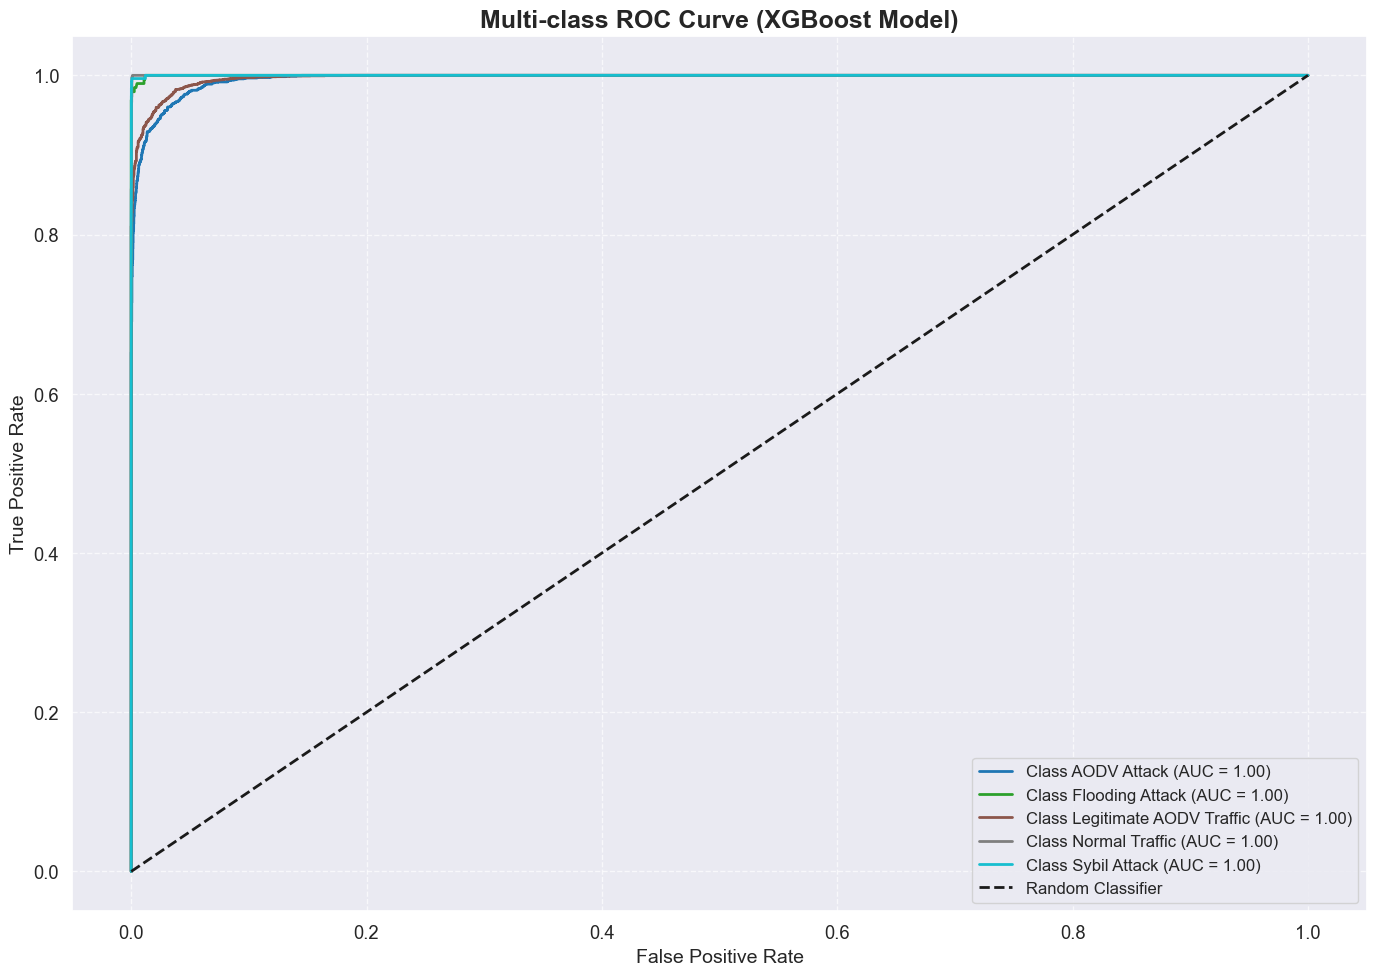

In [40]:
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Predict probabilities
y_score = best_xgb_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(label_encoder.classes_)))

for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f"Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})")

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Classifier")

# Add titles and labels
plt.title("Multi-class ROC Curve (XGBoost Model)", fontsize=18, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

# Add legend and grid
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("xgboost_model_multi_class_roc_curve.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [43]:
# Save the trained XGBoost model.
joblib.dump(best_xgb_model, "xgboost_uav_traffic_model.pkl")
print("\nModel saved as 'xgboost_uav_traffic_model.pkl'")


Model saved as 'xgboost_uav_traffic_model.pkl'
